# **Импорт библиотек**

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Препроцессинг изображений, создание датасетов**

In [149]:
train_data_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2,
                                          rotation_range=0.2)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [150]:
train_ds = train_data_generator.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    seed=123
)

test_ds = test_data_generator.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    seed=123
)



Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


# **Создание модели**

In [151]:
model = Sequential([
    layers.InputLayer(input_shape=(128,128,1)),
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation = "sigmoid")
])

In [152]:
model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy",metrics ="accuracy")

In [153]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 flatten_11 (Flatten)        (None, 32768)           

# **Обучение модели**

In [154]:
reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
stopper = EarlyStopping(monitor ='loss', patience=5, min_delta=0.001, mode='min')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max')

In [155]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.fit(batch_size=32,
        epochs=5,
        x=train_ds,
        validation_data=test_ds,
        callbacks = [reducer, stopper, checkpoint],
        verbose=1)

Epoch 1/5


2023-12-20 23:56:22.077096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 43s 134ms/step - loss: 0.2173 - accuracy: 0.9086 - val_loss: 0.1241 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 2/5
313/313 [==============================] - 42s 135ms/step - loss: 0.0947 - accuracy: 0.9665 - val_loss: 0.0522 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 3/5
313/313 [==============================] - 42s 133ms/step - loss: 0.0707 - accuracy: 0.9750 - val_loss: 0.0454 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 4/5
313/313 [==============================] - 42s 135ms/step - loss: 0.0649 - accuracy: 0.9771 - val_loss: 0.0483 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 5/5
313/313 [==============================] - 42s 135ms/step - loss: 0.0621 - accuracy: 0.9790 - val_loss: 0.0443 - val_accuracy: 0.9808 - lr: 0.0010


In [168]:
model.evaluate(test_ds)

31/31 [==============================] - 2s 79ms/step - loss: 0.0443 - accuracy: 0.9808


[0.04430878534913063, 0.9808467626571655]

# **Предсказания**

**Человек в маске**

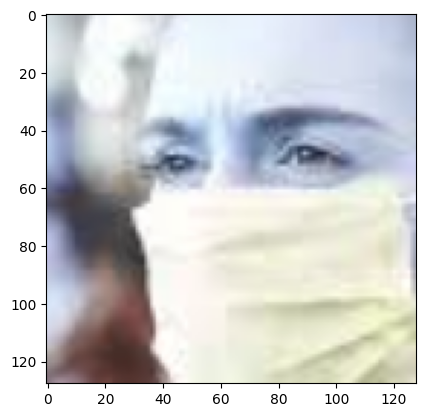

In [156]:
sample_mask_img = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/1007.png')
#sample_mask_img = cv2.cvtColor(sample_mask_img, cv2.COLOR_BGR2GRAY)
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = cv2.cvtColor(sample_mask_img, cv2.COLOR_BGR2GRAY)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,1])
sample_mask_img = sample_mask_img/255.0

In [157]:
sample_mask_img.shape

(1, 128, 128, 1)

In [158]:
model.predict(sample_mask_img)

1/1 [==============================] - 0s 68ms/step


array([[0.9056824 , 0.32989028]], dtype=float32)

**Человек без маски**

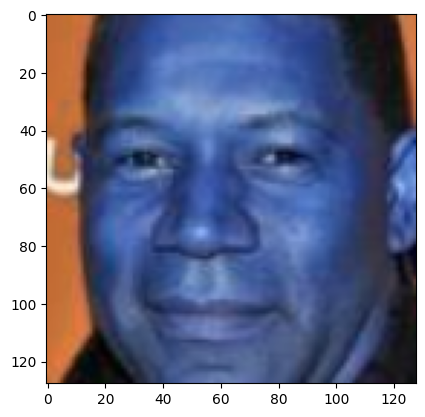

In [164]:
sample_nomask_img = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/1008.png')
#sample_nomask_img = cv2.cvtColor(sample_nomask_img, cv2.COLOR_BGR2GRAY)
sample_nomask_img = cv2.resize(sample_nomask_img,(128,128))
plt.imshow(sample_nomask_img)
sample_nomask_img = cv2.cvtColor(sample_nomask_img, cv2.COLOR_BGR2GRAY)
sample_nomask_img = np.reshape(sample_nomask_img,[1,128,128,1])
sample_nomask_img = sample_nomask_img/255.0

In [166]:
model.predict(sample_nomask_img)

1/1 [==============================] - 0s 19ms/step


array([[0.1181502 , 0.95566875]], dtype=float32)